# %% [markdown]
"""
## **Análise de Genes de Resistência a Salinidade**
**Objetivo**:  
Filtrar genes relacionados às estratégias **salt-in** e **salt-out** a partir da coluna `Preferred_name`, considerando variações comuns (ex: nhaP, nhaA, proP1, etc.).

**Método**:  
Busca flexível usando expressões regulares para capturar todas as variações dos genes da lista fornecida.
"""

In [35]:
# %%
import pandas as pd
import re
import numpy as np

# Configuração para exibir todas as colunas do DataFrame
pd.set_option('display.max_columns', None)

# Carregar arquivo (substitua pelo seu caminho)
file_path = "/Users/rvincenzi/Documents/USP/Doutorado/Tese/genomas_geral/genomica_comparativa/eggnog/p4d.annotations.xlsx"  # Ou .csv
df = pd.read_excel(file_path)

print(f"Total de genes/proteínas no arquivo: {len(df)}")
df.head(3)

Total de genes/proteínas no arquivo: 3208


,query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,EC,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
0,JDFEPHJD_00001,290398.Csal_0505,4.310000e-186,518.0,"COG1183@1|root,COG1183@2|Bacteria,1MWD9@1224|P...",135619|Oceanospirillales,I,Belongs to the CDP-alcohol phosphatidyltransfe...,pssA,-,2.7.8.8,ko:K17103,"ko00260,ko00564,ko01100,ko01110,map00260,map00...",M00093,R01800,"RC00002,RC00017,RC02795","ko00000,ko00001,ko00002,ko01000",-,-,-,CDP-OH_P_transf
1,JDFEPHJD_00002,290398.Csal_0504,4.740000e-243,667.0,"COG0059@1|root,COG0059@2|Bacteria,1MV7M@1224|P...",135619|Oceanospirillales,EH,Involved in the biosynthesis of branched-chain...,ilvC,-,1.1.1.86,ko:K00053,"ko00290,ko00770,ko01100,ko01110,ko01130,ko0121...","M00019,M00570","R03051,R04439,R04440,R05068,R05069,R05071","RC00726,RC00836,RC00837,RC01726","ko00000,ko00001,ko00002,ko01000",-,-,-,"IlvC,IlvN"
2,JDFEPHJD_00003,290398.Csal_0503,2.010000e-210,581.0,"COG0583@1|root,COG0583@2|Bacteria,1MZX1@1224|P...",135619|Oceanospirillales,K,transcriptional regulator,-,-,-,ko:K02521,-,-,-,-,"ko00000,ko03000",-,-,-,"HTH_1,LysR_substrate"


In [36]:
# %%
# Genes salt-in com variações
salt_in_patterns = [
    r"kdp[FABC]?\w*",      # kdpA, kdpB2, kdpF-1
    r"trk[AH]?\w*",        # trkA, trkH1
    r"nha[A-Za-z]+\w*",    # nhaP, nhaA1, nhaXYZ
    r"mrp[A-Za-z]*\w*",    # mrp, mrpA, mrpB2
    r"clc[A-Za-z]*\w*",    # clc, clcA
    r"halO\w*",            # halO, halO1
    r"phaP\w*"             # phaP, phaP2
]

# Genes salt-out com variações
salt_out_patterns = [
    r"opu[A-Za-z]+\w*",    # opuA, opuC1
    r"pro[A-Za-z]+\w*",    # proP, proU-1
    r"bet[A-Za-z]+\w*",    # betA, betB2
    r"tea[A-Za-z]+\w*",    # teaA, teaB1
    r"mts[A-Za-z]*\w*",    # mts, mtsT
    r"ots[A-Za-z]+\w*",    # otsA, otsB
    r"ect[A-Za-z]+\w*",    # ectA, ectB1
    r"dhp[A-Za-z]+\w*",    # dhpA, dhpB
    r"sigB\w*",            # sigB, sigB1
    r"glnK\w*",            # glnK, glnK2
    r"betI\w*",            # betI, betI-1
    r"pho[RB]\w*"          # phoR, phoB1
]

# Compilar regex combinadas
salt_in_regex = re.compile("|".join(salt_in_patterns), re.IGNORECASE)
salt_out_regex = re.compile("|".join(salt_out_patterns), re.IGNORECASE)

In [37]:
# %%
def classify_gene(preferred_name):
    """Classifica genes com base no padrão do nome"""
    if pd.isna(preferred_name):
        return None
    
    preferred_name = str(preferred_name)
    
    if salt_in_regex.search(preferred_name):
        return "salt-in"
    elif salt_out_regex.search(preferred_name):
        return "salt-out"
    else:
        return None

# Aplicar função
df["strategy"] = df["Preferred_name"].apply(classify_gene)
filtered_df = df.dropna(subset=["strategy"]).copy()

# Extrair o nome exato do gene encontrado
def extract_gene_name(preferred_name):
    if pd.isna(preferred_name):
        return None
    
    preferred_name = str(preferred_name)
    match = salt_in_regex.search(preferred_name) or salt_out_regex.search(preferred_name)
    return match.group() if match else None

filtered_df["gene_found"] = filtered_df["Preferred_name"].apply(extract_gene_name)

In [38]:
# %%
# Contagem de genes
summary = pd.DataFrame({
    "Estratégia": ["Salt-in", "Salt-out"],
    "Contagem": [
        sum(filtered_df["strategy"] == "salt-in"),
        sum(filtered_df["strategy"] == "salt-out")
    ]
})

# Top 10 genes mais frequentes
top_genes = filtered_df["gene_found"].value_counts().head(10)

print("\n📊 Resumo:")
display(summary)

print("\n🔝 Top 10 genes encontrados:")
display(top_genes)

print("\n🧬 Exemplos de entradas filtradas:")
filtered_df[["query", "Preferred_name", "gene_found", "strategy"]].head(10)


📊 Resumo:


,Estratégia,Contagem
0,Salt-in,5
1,Salt-out,20



🔝 Top 10 genes encontrados:


gene_found
opuCC    2
proB     1
proA     1
nhaP     1
opuCB    1
opuBA    1
proS     1
mrp      1
opuAC    1
ectC     1
Name: count, dtype: int64


🧬 Exemplos de entradas filtradas:


,query,Preferred_name,gene_found,strategy
28,JDFEPHJD_00029,proB,proB,salt-out
367,JDFEPHJD_00399,proA,proA,salt-out
390,JDFEPHJD_00429,betI,betI,salt-out
391,JDFEPHJD_00430,betB,betB,salt-out
933,JDFEPHJD_00999,mnhAB,nhAB,salt-in
1391,JDFEPHJD_01482,proC,proC,salt-out
1502,JDFEPHJD_01601,glnK,glnK,salt-out
1584,JDFEPHJD_01684,phoB,phoB,salt-out
1585,JDFEPHJD_01685,phoR,phoR,salt-out
1863,JDFEPHJD_01974,betT,betT,salt-out


/var/folders/hb/7z22q_f92bb8stzzy39dw7_80000gn/T/ipykernel_27837/897211268.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=filtered_df, x="strategy", palette={"salt-in": "blue", "salt-out": "red"})


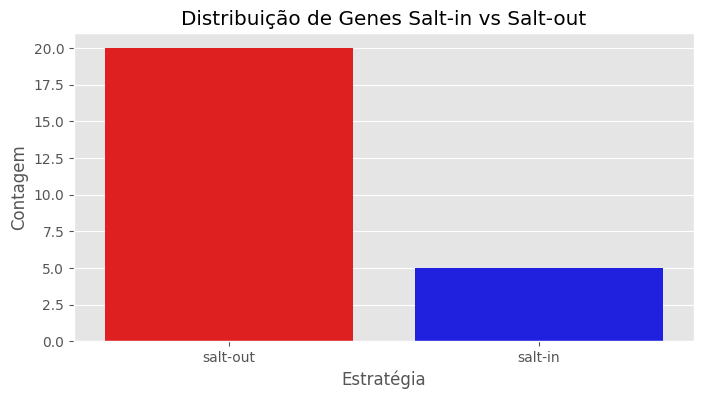

In [39]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de barras
plt.figure(figsize=(8, 4))
sns.countplot(data=filtered_df, x="strategy", palette={"salt-in": "blue", "salt-out": "red"})
plt.title("Distribuição de Genes Salt-in vs Salt-out")
plt.xlabel("Estratégia")
plt.ylabel("Contagem")
plt.show()

In [41]:
# %%
output_file = "p4d_genes_salt_filtrados.csv"
filtered_df.to_csv(output_file, index=False)
print(f"✅ Resultados exportados para '{output_file}'")



✅ Resultados exportados para 'p4d_genes_salt_filtrados.csv'
